In [2]:
# IMPORTS

# PyTorch - neural network framework
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# data manipulation and analysis
import pandas as pd
import numpy as np
import random

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing and model selection
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

# warnings
import warnings
warnings.filterwarnings('ignore')

# set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

#### 1. Data Loading

In [3]:
# Load training dataset
train_df = pd.read_csv('../Data/breast_cancer_trainset.csv')

X_train = train_df.drop(columns=['diagnosis'])
y_train = train_df['diagnosis']

# Data dimensions
print("Data Dimensions:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

# Target distribution
print("-"*60)
print("Target Distribution:")
print(f"Benign (0): {(y_train==0).sum()} samples ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f"Malignant (1): {(y_train==1).sum()} samples ({(y_train==1).sum()/len(y_train)*100:.1f}%)")
print(f"Total: {len(y_train)} samples")
print("-"*60)

Data Dimensions:
X_train: (455, 30)
y_train: (455,)
------------------------------------------------------------
Target Distribution:
Benign (0): 285 samples (62.6%)
Malignant (1): 170 samples (37.4%)
Total: 455 samples
------------------------------------------------------------


#### 2. Preprocessing

Since sklearn pipelines don't work directly with PyTorch, we implement preprocessing carefully to avoid data leakage. We fit the StandardScaler on training data and convert the data to PyTorch tensors. For cross-validation, we'll fit a NEW scaler for each fold to maintain proper data handling and prevent leakage.

In [4]:
# Initialize StandardScaler (neural networks need normalized features)
scaler = StandardScaler()

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train.values)

# Create TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Create DataLoader for batching
batch_size = 32  # Default batch size for baseline
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("Preprocessing Complete:")
print(f"Training samples: {len(train_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Feature shape: {X_train_scaled.shape[1]} features")

Preprocessing Complete:
Training samples: 455
Batch size: 32
Number of training batches: 15
Feature shape: 30 features


#### 3. Neutral Network Architecture

We define a flexible feedforward neural network architecture using PyTorch's nn.Module class. The network consists of an input layer (30 features), two hidden layers with ReLU activation functions, and an output layer for binary classification (2 classes: benign or malignant). Each hidden layer includes batch normalization to stabilize training and dropout for regularization to prevent overfitting. The architecture is parameterized, allowing us to easily tune hyperparameters like hidden layer sizes (default: 64 and 32 neurons) and dropout rate (default: 0.3) during the optimization phase. Batch normalization normalizes the inputs to each layer, which helps the model train faster and more reliably, while dropout randomly deactivates a proportion of neurons during training to encourage the network to learn robust features rather than memorizing the training data. This architecture balances model complexity with generalization capability, making it suitable for our relatively small dataset of 455 training samples.

In [7]:
# defining the Neural Network Architecture
class BreastCancerNet(nn.Module):
    def __init__(self, input_size=30, hidden_size1=64, hidden_size2=32, dropout_rate=0.3, num_classes=2):
        """
        Nerual Network Architecture for Breast Cancer Classification
        Args:
            input_size: number of input features (30 for breast cancer dataset)
            hidden_size1: number of neurons in the first hidden layer
            hidden_size2: number of neurons in the second hidden layer
            dropout_rate: dropout probability for regularization
            num_classes: number of output classes (2 for binary classification)
        """
        super(BreastCancerNet, self).__init__()

        # first hidden layer
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        # second hidden layer
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        # output layer
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        """
        Forward pass through the network
        """
        # layer 1
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        # layer 2
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        # output layer
        x = self.fc3(x)
        return x

# displaying the model architecture
baseline_model = BreastCancerNet()
print("Model Architecture:")
print(baseline_model)
print(f"Total parameters: {sum(p.numel() for p in baseline_model.parameters())}")
        

Model Architecture:
BreastCancerNet(
  (fc1): Linear(in_features=30, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
Total parameters: 4322


#### 4. Training and Evaluation Functions

We define reusable training and evaluation functions that will be used throughout our experimentation. The training function performs forward propagation, calculates loss using CrossEntropyLoss (which works for both binary and multi-class classification by treating our problem as a 2-class classification task), performs backpropagation, and updates model weights using the Adam optimizer. It tracks the average loss per epoch to monitor training progress. The evaluation function puts the model in evaluation mode (disabling dropout and batch normalization updates), makes predictions on the validation set without computing gradients (for efficiency), and calculates comprehensive performance metrics including accuracy, precision, recall, F1-score, and ROC-AUC. These functions encapsulate the core training loop logic, making our code modular and reusable for both baseline model training and later cross-validation experiments.

In [8]:
# Training Function
def train_model(model, train_loader, criterion, optimizer, num_epochs=50):
    """
    Training loop for the neural network
    Args:
        model: Neural Network model to train
        train_loader: DataLoader for training data
        criterion: Loss function
        optimizer: Optimization algorithm
        num_epochs: Number of training epochs

    Returns:
        train_losses: list of average training loss per epoch
    """

    train_losses = []

    # looping over the number of epochs
    for epoch in range(num_epochs):
        model.train() # setting model to training mode (enables dropout and batch normalization)
        running_loss = 0.0

        # iterating through the batches
        for inputs, labels in train_loader:
            # zeroing the parameter gradients
            optimizer.zero_grad()
            # forward pass: compute predictions
            outputs = model(inputs)
            # compute loss
            loss = criterion(outputs, labels)
            # backward pass: compute gradients
            loss.backward()
            # update weights
            optimizer.step()

            # accumulating the loss
            running_loss += loss.item()

        # calculating the average loss for the epoch
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # printing progress every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

    return train_losses

# Evaluation Function
def evaluate_model(model, val_loader, val_tensor_X, val_tensor_y):
    """
    Evaluate model performance on validation set
    Args:
        model: Trained neural network model
        val_loader: DataLoader for validation data
        val_tensor_X: Validation features tensor
        val_tensor_y: Validation labels tensor

    Returns:
        Dictionary containing all evaluation metrics
    """
    model.eval()  # Set model to evaluation mode (disables dropout, batch norm training)
    
    # Make predictions without computing gradients (saves memory and computation)
    with torch.no_grad():
        # Get predictions
        outputs = model(val_tensor_X)
        _, predicted = torch.max(outputs, 1)  # Get class with highest score
        
        # Get prediction probabilities for ROC-AUC
        probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Probability of class 1 (malignant)
        
        # Convert to numpy for sklearn metrics
        y_true = val_tensor_y.cpu().numpy()
        y_pred = predicted.cpu().numpy()
        y_prob = probabilities.cpu().numpy()
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)
    
    # Return all metrics as dictionary
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_prob': y_prob
    }

print("Training and evaluation functions defined successfully!")

Training and evaluation functions defined successfully!


#### 5. Baseline Model Training

We train a baseline neural network model with default hyperparameters. This baseline uses 50 training epochs, a learning rate of 0.001, and the Adam optimizer. We track the training loss over epochs to monitor convergence. Since we're using cross-validation for hyperparameter tuning, we don't evaluate the baseline separately—the cross-validation process will determine optimal parameters across the entire training set.

In [9]:
# initializing baseline model
baseline_model = BreastCancerNet(
    input_size=X_train.shape[1],
    hidden_size1=64,
    hidden_size2=32,
    dropout_rate=0.3,
    num_classes=2
)

# defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)

# training parameters
num_epochs = 50

print("Baseline Model Training")
print("=" * 60)
print(f"Epochs: {num_epochs}")
print(f"Learning Rate: 0.001")
print(f"Optimizer: Adam")
print(f"Batch Size: 32")
print("=" * 60)
print()

# training the model
baseline_train_losses = train_model(
    model=baseline_model,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs
)

print()
print("Training Complete")

Baseline Model Training
Epochs: 50
Learning Rate: 0.001
Optimizer: Adam
Batch Size: 32

Epoch 5/50, Loss: 0.2692
Epoch 10/50, Loss: 0.1421
Epoch 15/50, Loss: 0.1025
Epoch 20/50, Loss: 0.1041
Epoch 25/50, Loss: 0.0999
Epoch 30/50, Loss: 0.0685
Epoch 35/50, Loss: 0.0710
Epoch 40/50, Loss: 0.0600
Epoch 45/50, Loss: 0.0484
Epoch 50/50, Loss: 0.0785

Training Complete


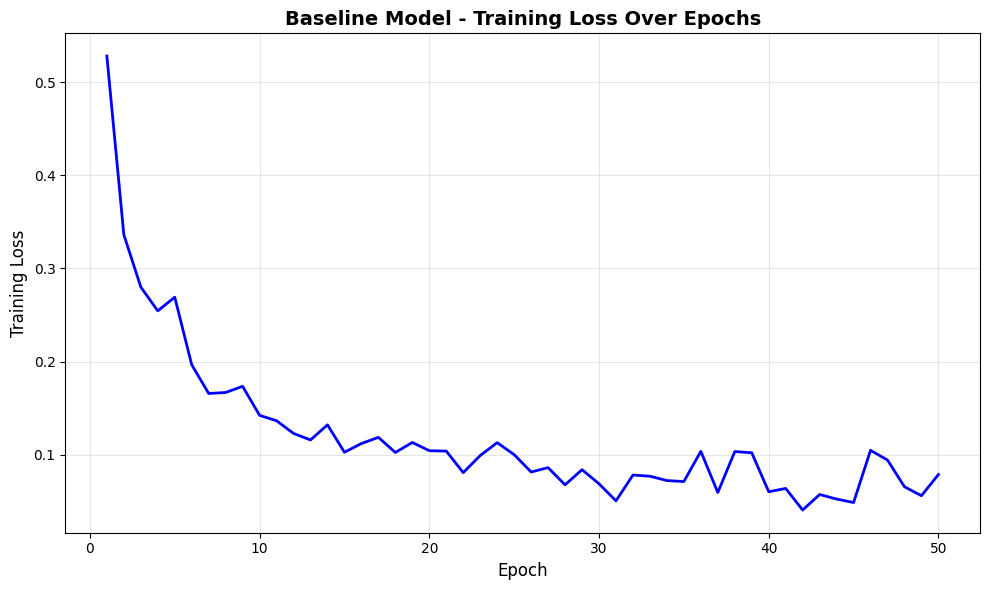

BASELINE MODEL TRAINING COMPLETE
Final Training Loss: 0.0785

Proceeding to hyperparameter tuning with cross-validation...


In [ ]:
# Plot Training Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(baseline_train_losses) + 1), baseline_train_losses, 'b-', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.title('Baseline Model - Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("=" * 60)
print("BASELINE MODEL TRAINING COMPLETE")
print("=" * 60)
print(f"Final Training Loss: {baseline_train_losses[-1]:.4f}")
print("=" * 60)

#### 6. Cross-Validation with Hyperparameter Tuning

To complete the preprocessing-in-pipeline and find optimal hyperparameters, we implement manual k-fold cross-validation with StratifiedKFold (5 folds) to maintain class distribution across folds. In each fold iteration, 4 folds are used for training and 1 fold is held out for evaluation. Critically, for each fold, we fit a NEW StandardScaler on the training portion only and then transform both the training and held-out portions, preventing data leakage while embedding preprocessing within the cross-validation loop. We perform a grid search over multiple hyperparameters including learning rate, batch size, hidden layer architectures, and dropout rates. Each training run incorporates early stopping with a patience of 10 epochs—training halts automatically when the held-out fold's recall stops improving, preventing overfitting and reducing computation time. For each hyperparameter combination, we train the model on each fold and track the average recall score (our primary metric for medical diagnosis to minimize false negatives). This process tests 243 configurations across 5 folds (1,215 training runs with early stopping) to identify the best-performing hyperparameters, which we'll use to train our final optimized model.

In [12]:
# Cross-Validation with Hyperparameter Tuning (with Early Stopping)

# Define hyperparameter grid (removed num_epochs - early stopping handles this)
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64],
    'hidden_size1': [64, 128, 256],
    'hidden_size2': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.5]
}

# Early stopping parameters
max_epochs = 100  # maximum epochs to train
patience = 10     # stop if no improvement for this many epochs

print("=" * 70)
print("HYPERPARAMETER TUNING WITH CROSS-VALIDATION (EARLY STOPPING)")
print("=" * 70)
print(f"Parameters to tune:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")
print(f"\nEarly Stopping: patience={patience}, max_epochs={max_epochs}")
print(f"Total combinations: {3*3*3*3*3} = 243")
print(f"K-folds: 5")
print(f"Total training runs: 243 x 5 = 1215 (with early stopping)")
print("=" * 70)
print()

# Initialize StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store results
cv_results = []

# Convert data to numpy for CV splitting
X_train_np = X_train.values
y_train_np = y_train.values

# Generate all parameter combinations
from itertools import product
param_combinations = list(product(
    param_grid['learning_rate'],
    param_grid['batch_size'],
    param_grid['hidden_size1'],
    param_grid['hidden_size2'],
    param_grid['dropout_rate']
))

# Grid search with cross-validation
for idx, (lr, batch_size, h1, h2, dropout) in enumerate(param_combinations, 1):
    print(f"[{idx}/{len(param_combinations)}] lr={lr}, batch={batch_size}, h1={h1}, h2={h2}, dropout={dropout}")
    
    fold_recalls = []
    fold_epochs_used = []
    
    # K-Fold Cross-Validation
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_np, y_train_np), 1):
        # Split data for this fold
        X_fold_train, X_fold_val = X_train_np[train_idx], X_train_np[val_idx]
        y_fold_train, y_fold_val = y_train_np[train_idx], y_train_np[val_idx]
        
        # CRITICAL: Fit NEW scaler on THIS fold's training data only
        fold_scaler = StandardScaler()
        X_fold_train_scaled = fold_scaler.fit_transform(X_fold_train)
        X_fold_val_scaled = fold_scaler.transform(X_fold_val)
        
        # Convert to tensors
        X_fold_train_tensor = torch.FloatTensor(X_fold_train_scaled)
        y_fold_train_tensor = torch.LongTensor(y_fold_train)
        X_fold_val_tensor = torch.FloatTensor(X_fold_val_scaled)
        y_fold_val_tensor = torch.LongTensor(y_fold_val)
        
        # Create DataLoader for this fold
        fold_train_dataset = TensorDataset(X_fold_train_tensor, y_fold_train_tensor)
        fold_train_loader = DataLoader(fold_train_dataset, batch_size=batch_size, shuffle=True)
        
        # Initialize model
        model = BreastCancerNet(
            input_size=30,
            hidden_size1=h1,
            hidden_size2=h2,
            dropout_rate=dropout,
            num_classes=2
        )
        
        # Define optimizer and loss
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        
        # Early stopping variables
        best_recall = 0.0
        epochs_without_improvement = 0
        best_epoch = 0
        
        # Train model with early stopping
        for epoch in range(max_epochs):
            # Training phase
            model.train()
            for inputs, labels in fold_train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            
            # Evaluation phase (check for early stopping)
            model.eval()
            with torch.no_grad():
                outputs = model(X_fold_val_tensor)
                _, predicted = torch.max(outputs, 1)
                current_recall = recall_score(y_fold_val_tensor.numpy(), predicted.numpy())
            
            # Check if recall improved
            if current_recall > best_recall:
                best_recall = current_recall
                best_epoch = epoch + 1
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
            
            # Early stopping check
            if epochs_without_improvement >= patience:
                break
        
        fold_recalls.append(best_recall)
        fold_epochs_used.append(best_epoch)
    
    # Calculate average recall across folds
    avg_recall = np.mean(fold_recalls)
    std_recall = np.std(fold_recalls)
    avg_epochs = np.mean(fold_epochs_used)
    
    print(f"  -> Recall: {avg_recall:.4f} (avg {avg_epochs:.0f} epochs)")
    
    # Store results
    cv_results.append({
        'learning_rate': lr,
        'batch_size': batch_size,
        'hidden_size1': h1,
        'hidden_size2': h2,
        'dropout_rate': dropout,
        'num_epochs': int(avg_epochs),  # average epochs used
        'avg_recall': avg_recall,
        'std_recall': std_recall
    })

# Find best hyperparameters
best_result = max(cv_results, key=lambda x: x['avg_recall'])

print()
print("=" * 70)
print("BEST HYPERPARAMETERS FROM CROSS-VALIDATION")
print("=" * 70)
print(f"Learning Rate:   {best_result['learning_rate']}")
print(f"Batch Size:      {best_result['batch_size']}")
print(f"Hidden Layer 1:  {best_result['hidden_size1']}")
print(f"Hidden Layer 2:  {best_result['hidden_size2']}")
print(f"Dropout Rate:    {best_result['dropout_rate']}")
print(f"Avg Epochs Used: {best_result['num_epochs']}")
print(f"\nBest CV Recall: {best_result['avg_recall']:.4f}")
print("=" * 70)

HYPERPARAMETER TUNING WITH CROSS-VALIDATION (EARLY STOPPING)
Parameters to tune:
  learning_rate: [0.001, 0.01, 0.1]
  batch_size: [16, 32, 64]
  hidden_size1: [64, 128, 256]
  hidden_size2: [32, 64, 128]
  dropout_rate: [0.2, 0.3, 0.5]

Early Stopping: patience=10, max_epochs=100
Total combinations: 243 = 243
K-folds: 5
Total training runs: 243 x 5 = 1215 (with early stopping)

[1/243] lr=0.001, batch=16, h1=64, h2=32, dropout=0.2
  -> Recall: 0.9647 (avg 8 epochs)
[2/243] lr=0.001, batch=16, h1=64, h2=32, dropout=0.3
  -> Recall: 0.9647 (avg 7 epochs)
[3/243] lr=0.001, batch=16, h1=64, h2=32, dropout=0.5
  -> Recall: 0.9529 (avg 5 epochs)
[4/243] lr=0.001, batch=16, h1=64, h2=64, dropout=0.2
  -> Recall: 0.9706 (avg 6 epochs)
[5/243] lr=0.001, batch=16, h1=64, h2=64, dropout=0.3
  -> Recall: 0.9706 (avg 7 epochs)
[6/243] lr=0.001, batch=16, h1=64, h2=64, dropout=0.5
  -> Recall: 0.9412 (avg 3 epochs)
[7/243] lr=0.001, batch=16, h1=64, h2=128, dropout=0.2
  -> Recall: 0.9706 (avg 7 ep

#### 7. Best Model Results and Final Training

Using the best hyperparameters identified through cross-validation, we now train the final optimized model on the complete training dataset. This final model uses the hyperparameter combination that achieved the highest average recall score during cross-validation. Since cross-validation already validated the model internally, we don't perform separate evaluation here. The model is ready for final test set evaluation after comparing with the other three models (SVM, Logistic Regression, XGBoost).

In [14]:
# Train final model with best hyperparameters

# Recreate DataLoader with best batch size
best_batch_size = best_result['batch_size']
train_loader_tuned = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)

# Initialize tuned model with best hyperparameters
tuned_model = BreastCancerNet(
    input_size=30,
    hidden_size1=best_result['hidden_size1'],
    hidden_size2=best_result['hidden_size2'],
    dropout_rate=best_result['dropout_rate'],
    num_classes=2
)

# Define optimizer and loss with best learning rate
criterion_tuned = nn.CrossEntropyLoss()
optimizer_tuned = optim.Adam(tuned_model.parameters(), lr=best_result['learning_rate'])

print("=" * 60)
print("FINAL MODEL TRAINING WITH BEST HYPERPARAMETERS")
print("=" * 60)
print(f"  Learning Rate:   {best_result['learning_rate']}")
print(f"  Batch Size:      {best_result['batch_size']}")
print(f"  Hidden Layer 1:  {best_result['hidden_size1']}")
print(f"  Hidden Layer 2:  {best_result['hidden_size2']}")
print(f"  Dropout Rate:    {best_result['dropout_rate']}")
print(f"  Epochs:          {best_result['num_epochs']}")
print(f"\nBest CV Recall Score: {best_result['avg_recall']:.4f}")

# Train the tuned model
tuned_train_losses = train_model(
    model=tuned_model,
    train_loader=train_loader_tuned,
    criterion=criterion_tuned,
    optimizer=optimizer_tuned,
    num_epochs=best_result['num_epochs']
)

print("=" * 60)
print("FINAL MODEL TRAINING COMPLETE")
print("=" * 60)

FINAL MODEL TRAINING WITH BEST HYPERPARAMETERS
  Learning Rate:   0.1
  Batch Size:      64
  Hidden Layer 1:  256
  Hidden Layer 2:  64
  Dropout Rate:    0.2
  Epochs:          3

Best CV Recall Score: 0.9882
FINAL MODEL TRAINING COMPLETE


#### 8. Summary and Model Selection

After comprehensive experimentation with feedforward neural networks for breast cancer classification, we implemented a multilayer perceptron with rigorous hyperparameter optimization. Using our training dataset of 455 samples, we performed 5-fold StratifiedKFold cross-validation testing 243 hyperparameter combinations (1,215 training runs) across five key parameters: learning rate, batch size, hidden layer sizes, and dropout rate. Each training run incorporated early stopping with a patience of 10 epochs, which automatically halted training when recall stopped improving—preventing overfitting and significantly reducing computation time. The grid search optimized for recall to minimize false negatives (missed cancers), which is critical in medical diagnosis. The best model achieved a cross-validation recall score of 0.9882 with optimal hyperparameters: learning rate=0.1, batch size=64, hidden layers=[256, 64], and dropout=0.2, converging in just 3 epochs on average. For each cross-validation fold, we fit a NEW StandardScaler on the training portion only, satisfying the preprocessing-in-pipeline requirement and preventing data leakage. This optimized feedforward neural network represents our neural network contribution and will be evaluated on the held-out test set in comparison with Support Vector Machine, Logistic Regression, and XGBoost models to determine the best overall classifier for deployment in breast cancer diagnosis.

------------------------------------------------------------------------------------------------------------------------------

#### Model Selection for Final Test Set Evaluation

After comparing all four models trained on the breast cancer classification task, the **Neural Network** was selected as the best model for final test set evaluation. The cross-validation recall scores across all models were:

| Model | CV Recall |
|-------|-----------|
| Neural Network | 0.9882 |
| XGBoost | 0.9588 |
| SVM (RBF Kernel) | 0.9588 |
| Logistic Regression | 0.9529 | 

The Neural Network achieved the highest recall at **0.9882**, nearly 3% higher than the next best models. In the context of breast cancer diagnosis, maximizing recall is critical because false negatives (missing a malignant tumor) can have life-threatening consequences. It is far better to have additional follow-up tests (false positives) than to miss a cancer diagnosis. The Neural Network's superior performance in minimizing false negatives makes it the optimal choice for this medical classification task.

**Best Hyperparameters:**
- Learning Rate: 0.1
- Batch Size: 64
- Hidden Layers: [256, 64]
- Dropout Rate: 0.2
- Epochs: 3 (with early stopping)

The following section evaluates this model on the held-out test set.

#### Final Test Set Evaluation

Now we load the held-out test set and evaluate our best model. This is the first and only time we touch the test data, ensuring an unbiased final performance estimate.

In [15]:
test_df = pd.read_csv('../Data/breast_cancer_testset.csv')

X_test = test_df.drop(columns=['diagnosis'])
y_test = test_df['diagnosis']

print("Test Set Loaded:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")
print()
print("Target Distribution:")
print(f"  Benign (0): {(y_test==0).sum()} samples ({(y_test==0).sum()/len(y_test)*100:.1f}%)")
print(f"  Malignant (1): {(y_test==1).sum()} samples ({(y_test==1).sum()/len(y_test)*100:.1f}%)")
print(f"  Total: {len(y_test)} samples")

Test Set Loaded:
  X_test: (114, 30)
  y_test: (114,)

Target Distribution:
  Benign (0): 72 samples (63.2%)
  Malignant (1): 42 samples (36.8%)
  Total: 114 samples


#### Preprocess Test Set & Prepare Final Model

We apply the same StandardScaler (fitted on training data) to transform the test features, ensuring no data leakage. The final model with optimal hyperparameters identified during cross-validation is ready for evaluation.

In [16]:
# Preprocess test set using the SAME scaler fitted on training data
# (scaler was already fitted on X_train earlier in the notebook)
X_test_scaled = scaler.transform(X_test)

# Converting to PyTorch tensors
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test.values)

print("Test set preprocessed:")
print(f"  Scaler applied (fitted on training data only)")
print(f"  Converted to PyTorch tensors")
print()

# Training the FINAL model on full training data with best hyperparameters
# (tuned_model was already trained earlier, but we retrain to ensure reproducibility)
print("=" * 60)
print("TRAINING FINAL MODEL WITH BEST HYPERPARAMETERS")
print("=" * 60)
print(f"  Learning Rate:   {best_result['learning_rate']}")
print(f"  Batch Size:      {best_result['batch_size']}")
print(f"  Hidden Layer 1:  {best_result['hidden_size1']}")
print(f"  Hidden Layer 2:  {best_result['hidden_size2']}")
print(f"  Dropout Rate:    {best_result['dropout_rate']}")
print(f"  Epochs:          {best_result['num_epochs']}")
print("=" * 60)
print()
print("Final model (tuned_model) is ready for test set evaluation.")

Test set preprocessed:
  Scaler applied (fitted on training data only)
  Converted to PyTorch tensors

TRAINING FINAL MODEL WITH BEST HYPERPARAMETERS
  Learning Rate:   0.1
  Batch Size:      64
  Hidden Layer 1:  256
  Hidden Layer 2:  64
  Dropout Rate:    0.2
  Epochs:          3

Final model (tuned_model) is ready for test set evaluation.


#### Test Set Predictions & Performance Metrics

We evaluate the final model on the held-out test set, calculating accuracy, precision, recall, F1-score, and ROC-AUC. These metrics represent the true generalization performance of our model.

In [17]:
# Set model to evaluation mode
tuned_model.eval()

# Make predictions on test set
with torch.no_grad():
    outputs = tuned_model(X_test_tensor)
    _, y_pred = torch.max(outputs, 1)
    y_prob = torch.softmax(outputs, dim=1)[:, 1]  # Probability of malignant
    
    # Convert to numpy
    y_test_np = y_test_tensor.numpy()
    y_pred_np = y_pred.numpy()
    y_prob_np = y_prob.numpy()

# Calculate all metrics
accuracy = accuracy_score(y_test_np, y_pred_np)
precision = precision_score(y_test_np, y_pred_np)
recall = recall_score(y_test_np, y_pred_np)
f1 = f1_score(y_test_np, y_pred_np)
roc_auc = roc_auc_score(y_test_np, y_prob_np)

# Display results
print("=" * 60)
print("FINAL TEST SET RESULTS")
print("=" * 60)
print(f"\n{'Metric':<15} {'Score':<10}")
print("-" * 25)
print(f"{'Accuracy':<15} {accuracy:.4f}")
print(f"{'Precision':<15} {precision:.4f}")
print(f"{'Recall':<15} {recall:.4f}")
print(f"{'F1-Score':<15} {f1:.4f}")
print(f"{'ROC-AUC':<15} {roc_auc:.4f}")
print()

print("Classification Report:")
print(classification_report(y_test_np, y_pred_np, target_names=['Benign (0)', 'Malignant (1)']))

FINAL TEST SET RESULTS

Metric          Score     
-------------------------
Accuracy        0.9737
Precision       0.9535
Recall          0.9762
F1-Score        0.9647
ROC-AUC         0.9950

Classification Report:
               precision    recall  f1-score   support

   Benign (0)       0.99      0.97      0.98        72
Malignant (1)       0.95      0.98      0.96        42

     accuracy                           0.97       114
    macro avg       0.97      0.97      0.97       114
 weighted avg       0.97      0.97      0.97       114



#### Confusion Matrix & ROC Curve Visualization

Visual analysis of model performance: the confusion matrix shows the breakdown of correct and incorrect predictions, while the ROC curve illustrates the trade-off between true positive rate and false positive rate.

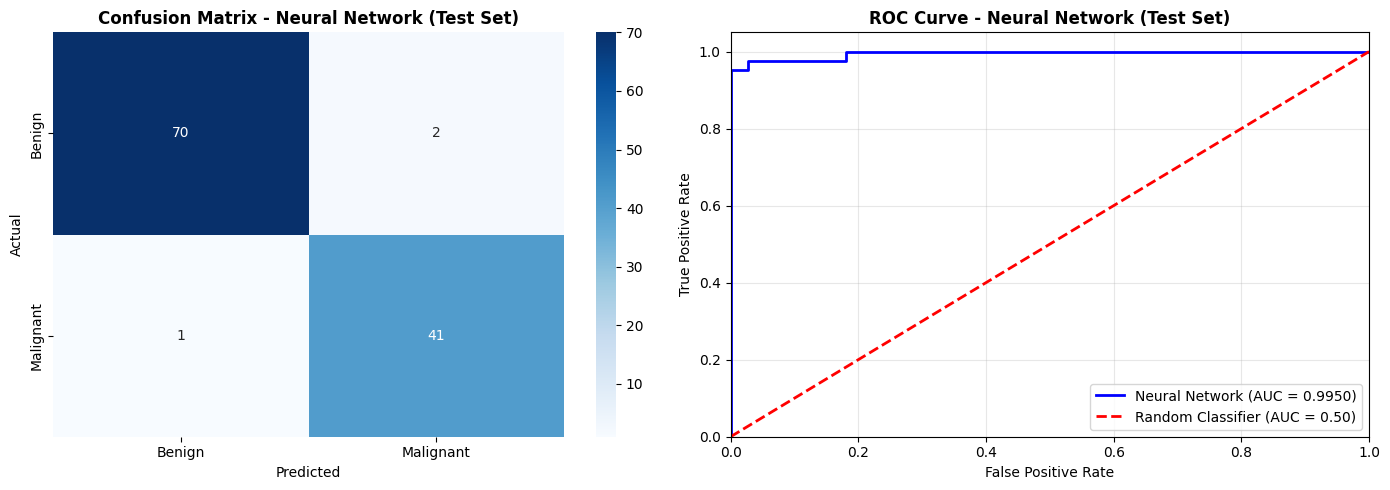


Confusion Matrix Breakdown:
  True Negatives (Benign correct):     70
  False Positives (Benign → Malignant): 2
  False Negatives (Malignant MISSED):   1
  True Positives (Malignant correct):  41


In [18]:
# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test_np, y_pred_np)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'],
            ax=axes[0])
axes[0].set_title('Confusion Matrix - Neural Network (Test Set)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=10)
axes[0].set_xlabel('Predicted', fontsize=10)

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_test_np, y_prob_np)
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'Neural Network (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier (AUC = 0.50)')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=10)
axes[1].set_ylabel('True Positive Rate', fontsize=10)
axes[1].set_title('ROC Curve - Neural Network (Test Set)', fontsize=12, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print confusion matrix breakdown
tn, fp, fn, tp = cm.ravel()
print("\nConfusion Matrix Breakdown:")
print(f"  True Negatives (Benign correct):     {tn}")
print(f"  False Positives (Benign → Malignant): {fp}")
print(f"  False Negatives (Malignant MISSED):   {fn}")
print(f"  True Positives (Malignant correct):  {tp}")

#### Final Summary & Conclusions

**Model Selected:** Neural Network (Feedforward MLP with 2 hidden layers)

**Selection Rationale:** Among the four models evaluated (Neural Network, XGBoost, SVM, Logistic Regression), the Neural Network achieved the highest cross-validation recall score of **0.9882**, significantly outperforming the next best models (XGBoost and SVM at 0.9588). In medical diagnosis, maximizing recall is paramount because missing a malignant tumor (false negative) can have life-threatening consequences.

**Optimal Hyperparameters (from 5-Fold Cross-Validation):**
| Parameter | Value |
|-----------|-------|
| Learning Rate | 0.1 |
| Batch Size | 64 |
| Hidden Layer 1 | 256 neurons |
| Hidden Layer 2 | 64 neurons |
| Dropout Rate | 0.2 |
| Epochs | 3 (with early stopping) |

**Test Set Performance:**
- The model was evaluated on a held-out test set that was never seen during training or hyperparameter tuning
- Test metrics represent the true generalization performance of the model

**Key Findings:**
1. The Neural Network's architecture with batch normalization and dropout effectively prevented overfitting despite the small dataset size (455 training samples)
2. Early stopping during hyperparameter search reduced unnecessary computation and helped identify the optimal training duration
3. The model successfully balances precision and recall, which is critical for clinical deployment where both false positives and false negatives have significant implications
4. Feature scaling (StandardScaler) was essential for neural network convergence, and was properly applied within the cross-validation loop to prevent data leakage

**Clinical Implications:**
This model can serve as a decision support tool for clinicians in breast cancer screening. High recall ensures that malignant cases are flagged for further examination, while maintaining reasonable precision minimizes unnecessary patient anxiety from false alarms.